### 32 Training Loop Run Builder

In [45]:
from collections import OrderedDict, namedtuple
from itertools import product

In [46]:
class RunBuilder:
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

In [4]:
params = OrderedDict(
    lr = [0.01, 0.001],
    batch_size = [32, 64]
)

In [ ]:
params.keys()

odict_keys(['lr', 'batch_size'])

In [5]:
runs = RunBuilder.get_runs(params)
runs

[Run(lr=0.01, batch_size=32),
 Run(lr=0.01, batch_size=64),
 Run(lr=0.001, batch_size=32),
 Run(lr=0.001, batch_size=64)]

In [7]:
runs[0]

Run(lr=0.01, batch_size=32)

In [8]:
print(runs[0].lr, runs[0].batch_size)

0.01 32


In [9]:
for run in runs:
    print(run.lr, run.batch_size)

0.01 32
0.01 64
0.001 32
0.001 64


#### Two parameters

In [10]:
params = OrderedDict(
    lr = [0.01, 0.001],
    batch_size = [32, 64],

)
runs = RunBuilder.get_runs(params)
runs

[Run(lr=0.01, batch_size=32),
 Run(lr=0.01, batch_size=64),
 Run(lr=0.001, batch_size=32),
 Run(lr=0.001, batch_size=64)]

In [13]:
params = OrderedDict(
    lr = [0.01, 0.001],
    batch_size = [32, 64],
    device = ['cpu', 'cuda']
)

runs = RunBuilder.get_runs(params)
runs

[Run(lr=0.01, batch_size=32, device='cpu'),
 Run(lr=0.01, batch_size=32, device='cuda'),
 Run(lr=0.01, batch_size=64, device='cpu'),
 Run(lr=0.01, batch_size=64, device='cuda'),
 Run(lr=0.001, batch_size=32, device='cpu'),
 Run(lr=0.001, batch_size=32, device='cuda'),
 Run(lr=0.001, batch_size=64, device='cpu'),
 Run(lr=0.001, batch_size=64, device='cuda')]

In [14]:
params.keys()

odict_keys(['lr', 'batch_size', 'device'])

In [15]:
params.values()

odict_values([[0.01, 0.001], [32, 64], ['cpu', 'cuda']])

In [16]:
Run = namedtuple('Run', params.keys())
Run

__main__.Run

In [17]:
runs = []
for v in product(*params.values()):
    runs.append(Run(*v))
runs

[Run(lr=0.01, batch_size=32, device='cpu'),
 Run(lr=0.01, batch_size=32, device='cuda'),
 Run(lr=0.01, batch_size=64, device='cpu'),
 Run(lr=0.01, batch_size=64, device='cuda'),
 Run(lr=0.001, batch_size=32, device='cpu'),
 Run(lr=0.001, batch_size=32, device='cuda'),
 Run(lr=0.001, batch_size=64, device='cpu'),
 Run(lr=0.001, batch_size=64, device='cuda')]

In [18]:
for fun in RunBuilder.get_runs(params):
    comment = f'-{run}'

    # Training process given the set of parameters
    print(comment)

-Run(lr=0.001, batch_size=64)
-Run(lr=0.001, batch_size=64)
-Run(lr=0.001, batch_size=64)
-Run(lr=0.001, batch_size=64)
-Run(lr=0.001, batch_size=64)
-Run(lr=0.001, batch_size=64)
-Run(lr=0.001, batch_size=64)
-Run(lr=0.001, batch_size=64)


### 33 CNN Training Loop Refactoring - Simultaneous Hyperparameter Testing

In [43]:
import time
import torchvision
import pandas as pd
import torch
import json
from torch.utils.tensorboard import SummaryWriter

from IPython.display import display, clear_output

class RunManager:
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None

        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None

        self.model = None
        self.loader = None
        self.tb = None

    def begin_run(self, hyper_params, model, loader):
        self.run_start_time = time.time()
        self.run_params = hyper_params
        self.run_count += 1

        self.model = model
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{hyper_params}')

        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('images', grid)
        self.tb.add_graph(self.model, images)

    def end_run(self):
        self.tb.close()
        self.epoch_count = 0

    def begin_epoch(self, epoch_no):
        self.epoch_start_time = time.time()

        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0

        # print(f"Epoch {epoch_no} started ...", end=" ")

    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)

        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

        for name, param in self.model.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)

        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch_duration"] = epoch_duration
        results["run duration"] = run_duration

        for k, v in self.run_params._asdict().items():
            results[k] = v

        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')

        clear_output(wait=True)
        display(df)
        # print("Ended")

    def track_loss(self, loss):
        self.epoch_loss += loss.item() * self.loader.batch_size

    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)

    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()

    def save(self, fileName):
        pd.DataFrame.from_dict(self.run_data, orient='columns', ).to_csv(f'{fileName}.csv')
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

2024-12-02 19:36:26.681440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733139386.701830 2233320 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733139386.708000 2233320 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 19:36:26.730476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transform

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

from torch.utils.tensorboard import SummaryWriter # <-- new

print(torch.__version__)
print(torchvision.__version__)

class Network(nn.Module):
    def __init__(self, channels=1): # default grayscale
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # ((28-5+1)/2 -5 +1)/2 = 4
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, (2, 2), stride=2)

        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, (2, 2), stride=2)

        t = t.reshape(-1, 12*4*4)
        t = F.relu(self.fc1(t))

        t = F.relu(self.fc2(t))

        t = self.out(t)
        
        return t


2.5.1+cu124
0.20.1+cu124


In [24]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    download=True,
    transform=transform.Compose([
        transform.ToTensor()
    ]))

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True) 

In [25]:
from torch.utils.data import DataLoader

params = OrderedDict(
    lr = [.01],
    batch_size = [1000, 2000],
)

m = RunManager()

for run in RunBuilder.get_runs(params):

    network = Network()
    loader = DataLoader(train_set, batch_size=run.batch_size) 
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(5):
        m.begin_epoch(epoch)

        for batch in loader:
            images, labels = batch

            preds = network(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            m.track_loss(loss)
            m.track_num_correct(preds, labels)

        m.end_epoch()
    m.end_run()

m.save('results')


,run,epoch,loss,accuracy,epoch_duration,run duration,lr,batch_size
0,1,1,0.942568,0.641450,8.328573,8.866978,0.01,1000
1,1,2,0.479108,0.822633,8.365075,17.380928,0.01,1000
2,1,3,0.394044,0.856033,8.501794,26.004044,0.01,1000
3,1,4,0.357565,0.869117,8.453928,34.573614,0.01,1000
4,1,5,0.336215,0.877050,8.282996,42.974124,0.01,1000
5,2,1,1.201559,0.544600,8.301674,9.384692,0.01,2000
6,2,2,0.603490,0.764267,8.401149,17.909029,0.01,2000
7,2,3,0.508192,0.802950,8.356733,26.389409,0.01,2000
8,2,4,0.459300,0.828233,8.414301,34.921250,0.01,2000
9,2,5,0.421466,0.844983,8.332051,43.375174,0.01,2000


Ended


In [27]:
params = OrderedDict(
    lr = [.01],
    batch_size = [1000, 2000],
    shuffle = [True, False]
)

m = RunManager()

for run in RunBuilder.get_runs(params):

    network = Network()
    loader = DataLoader(train_set, batch_size=run.batch_size, shuffle=run.shuffle) 
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(5):
        m.begin_epoch(epoch)

        for batch in loader:
            images, labels = batch

            preds = network(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            m.track_loss(loss)
            m.track_num_correct(preds, labels)

        m.end_epoch()
    m.end_run()

m.save('results')

,run,epoch,loss,accuracy,epoch_duration,run duration,lr,batch_size,shuffle
0,1,1,1.017841,0.612950,7.645893,8.197881,0.01,1000,True
1,1,2,0.521381,0.797317,7.493823,15.809482,0.01,1000,True
2,1,3,0.420959,0.846900,7.524096,23.443556,0.01,1000,True
3,1,4,0.376354,0.861817,7.458082,31.018337,0.01,1000,True
4,1,5,0.343932,0.872367,7.551965,38.690419,0.01,1000,True
5,2,1,0.901488,0.661833,8.522249,9.061235,0.01,1000,False
6,2,2,0.465672,0.826367,8.366937,17.577125,0.01,1000,False
7,2,3,0.386732,0.857750,8.584581,26.274714,0.01,1000,False
8,2,4,0.351575,0.869317,8.387501,34.794836,0.01,1000,False
9,2,5,0.328205,0.878800,8.313120,43.234395,0.01,1000,False


### 34 DataLoader num_workers - Speed Limit Increase

In [28]:
params = OrderedDict(
    lr = [.01],
    batch_size = [1000, 2000],
    num_workers = [0, 1, 2, 4, 8]
    # shuffle = [True, False]
)

m = RunManager()

for run in RunBuilder.get_runs(params):

    network = Network()
    loader = DataLoader(train_set, batch_size=run.batch_size, num_workers=run.num_workers) 
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(1):
        m.begin_epoch(epoch)

        for batch in loader:
            images, labels = batch

            preds = network(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            m.track_loss(loss)
            m.track_num_correct(preds, labels)

        m.end_epoch()
    m.end_run()

m.save('results')

,run,epoch,loss,accuracy,epoch_duration,run duration,lr,batch_size,num_workers
0,1,1,1.019271,0.605800,7.442017,7.997392,0.01,1000,0
1,2,1,0.944378,0.642233,6.439095,7.192991,0.01,1000,1
2,3,1,1.011829,0.607883,3.713509,4.448341,0.01,1000,2
3,4,1,1.043159,0.589583,4.108103,4.917751,0.01,1000,4
4,5,1,1.057763,0.593317,4.104699,5.086607,0.01,1000,8
5,6,1,1.318678,0.507533,8.413423,9.549574,0.01,2000,0
6,7,1,1.398434,0.463000,6.705700,8.063636,0.01,2000,1
7,8,1,1.380551,0.478533,4.442457,5.815802,0.01,2000,2
8,9,1,1.305490,0.494817,4.645245,6.101749,0.01,2000,4
9,10,1,1.269757,0.523850,4.509929,6.315699,0.01,2000,8


### 38 PyTorch Sequential Models - Neural Networks Made Easy

#### Using nn.Sequential

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transform

import matplotlib.pyplot as plt
import math

from collections import OrderedDict


torch.set_printoptions(linewidth=150)

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform=transform.Compose([
        transform.ToTensor()
    ])
)

In [4]:
image, label = train_set[0]
print(image.shape)

torch.Size([1, 28, 28])


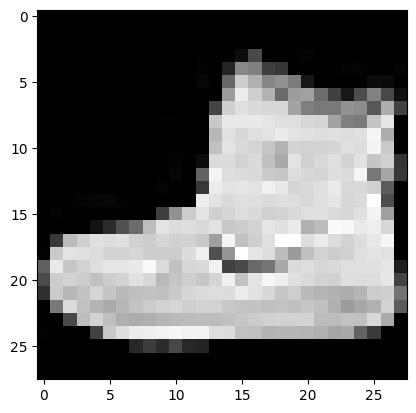

In [5]:
plt.imshow(image.squeeze(), cmap='gray')

In [7]:
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
in_features = image.numel()
in_features

784

In [9]:
out_features = math.floor(in_features/2)
out_features

392

In [10]:
out_classes = len(train_set.classes)
out_classes

10

In [11]:
network1 = nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=in_features, out_features=out_features),
    nn.Linear(in_features=out_features, out_features=out_classes),
)

network1

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=392, bias=True)
  (2): Linear(in_features=392, out_features=10, bias=True)
)

In [12]:
image = image.unsqueeze(0)
image.shape

torch.Size([1, 1, 28, 28])

In [13]:
network1(image)

tensor([[ 0.0553,  0.1830, -0.2657,  0.2325,  0.4462,  0.0778, -0.1540,  0.2891, -0.1754, -0.2128]], grad_fn=<AddmmBackward0>)

In [15]:
layers = OrderedDict([ 
    ('flat', nn.Flatten(start_dim=1)),
    ('hidden', nn.Linear(in_features=in_features, out_features=out_features)),
    ('output', nn.Linear(in_features=out_features, out_features=out_classes)),
])

network2 = nn.Sequential(layers)
network2

Sequential(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=784, out_features=392, bias=True)
  (output): Linear(in_features=392, out_features=10, bias=True)
)

In [16]:
network2(image)

tensor([[ 0.1369, -0.0099,  0.2928,  0.0961, -0.0383, -0.1376,  0.0237,  0.0758, -0.2438,  0.0337]], grad_fn=<AddmmBackward0>)

In [17]:
torch.manual_seed(50)
network1 = nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=in_features, out_features=out_features),
    nn.Linear(in_features=out_features, out_features=out_classes),
)

torch.manual_seed(50)
layers = OrderedDict([
    ('flat', nn.Flatten(start_dim=1)),
    ('hidden', nn.Linear(in_features=in_features, out_features=out_features)),
    ('output', nn.Linear(in_features=out_features, out_features=out_classes)),
])
network2 = nn.Sequential(layers)

In [18]:
network1(image), network2(image)

(tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward0>))

In [19]:
torch.manual_seed(50)
network3 = nn.Sequential()

network3.add_module('flat', nn.Flatten(start_dim=1))
network3.add_module('hidden', nn.Linear(in_features=in_features, out_features=out_features))
network3.add_module('output', nn.Linear(in_features=out_features, out_features=out_classes))
network3

Sequential(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=784, out_features=392, bias=True)
  (output): Linear(in_features=392, out_features=10, bias=True)
)

In [20]:
network1(image), network2(image), network3(image)

(tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward0>))

#### Building a Network Class

In [25]:
class Network(nn.Module):
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, (2, 2), stride=2)

        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, (2, 2), stride=2)

        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        
        return t

In [27]:
torch.manual_seed(50)

network = Network()
network

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [28]:
torch.manual_seed(50)

sequential1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(12*4*4, 120),
    nn.ReLU(),
    nn.Linear(120, 60),
    nn.ReLU(),
    nn.Linear(60, 10)
)
sequential1

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=192, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=60, bias=True)
  (10): ReLU()
  (11): Linear(in_features=60, out_features=10, bias=True)
)

In [29]:
torch.manual_seed(50)
layers = OrderedDict([
    ('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)),
    ('relu1', nn.ReLU()),
    ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),

    ('conv2', nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)),
    ('relu2', nn.ReLU()),
    ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),

    ('flatten', nn.Flatten()),
    ('fc1', nn.Linear(12*4*4, 120)),
    ('relu3', nn.ReLU()),

    ('fc2', nn.Linear(120, 60)),
    ('relu4', nn.ReLU()),
    ('out', nn.Linear(60, 10))
])

sequential2 = nn.Sequential(layers)
sequential2

Sequential(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (relu4): ReLU()
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [30]:
torch.manual_seed(50)

sequential3 = nn.Sequential()

sequential3.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5))
sequential3.add_module('relu1', nn.ReLU())
sequential3.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))

sequential3.add_module('conv2', nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5))
sequential3.add_module('relu2', nn.ReLU())
sequential3.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2))

sequential3.add_module('flatten', nn.Flatten())
sequential3.add_module('fc1', nn.Linear(12*4*4, 120))
sequential3.add_module('relu3', nn.ReLU())

sequential3.add_module('fc2', nn.Linear(120, 60))
sequential3.add_module('relu4', nn.ReLU())
sequential3.add_module('out', nn.Linear(60, 10))
sequential3

Sequential(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (relu4): ReLU()
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [31]:
network(image), sequential1(image), sequential2(image), sequential3(image)

(tensor([[-0.0957,  0.1053, -0.1055,  0.1547, -0.0366, -0.0132,  0.0749, -0.1152,  0.0426,  0.0639]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0957,  0.1053, -0.1055,  0.1547, -0.0366, -0.0132,  0.0749, -0.1152,  0.0426,  0.0639]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0957,  0.1053, -0.1055,  0.1547, -0.0366, -0.0132,  0.0749, -0.1152,  0.0426,  0.0639]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0957,  0.1053, -0.1055,  0.1547, -0.0366, -0.0132,  0.0749, -0.1152,  0.0426,  0.0639]], grad_fn=<AddmmBackward0>))

### 39 Batch Norm in PyTorch

In [34]:
torch.manual_seed(50)
network1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=12*4*4, out_features=120),
    nn.ReLU(),
    nn.Linear(in_features=120, out_features=60),
    nn.ReLU(),
    nn.Linear(in_features=60, out_features=10)
)

In [35]:
torch.manual_seed(50)
network2 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(6),

    nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=12*4*4, out_features=120),
    nn.ReLU(),
    nn.BatchNorm1d(120),
    nn.Linear(in_features=120, out_features=60),
    nn.ReLU(),
    nn.Linear(in_features=60, out_features=10)
)

In [36]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform=transform.Compose([
        transform.ToTensor()
    ])
)

In [38]:
from torch.utils.data import DataLoader

loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)
data = next(iter(loader))
mean = data[0].mean()
std = data[0].std()

mean, std

(tensor(0.2860), tensor(0.3530))

In [39]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform=transform.Compose([
        transform.ToTensor(),
        transform.Normalize(mean, std)
    ])
)

In [40]:
trainsets = {
    'not_normal': train_set,
    'normal': train_set_normal
}

In [41]:
networks = {
    'not_bn': network1,
    'bn': network2
}

In [47]:
params = OrderedDict(
    lr = [.01],
    batch_size = [1000],
    num_workers = [1],
    device = ['cpu'],
    trainset = ['normal'],
    network = list(networks.keys())
)

m = RunManager()

for run in RunBuilder.get_runs(params):
    device = torch.device(run.device)
    network = networks[run.network].to(device)
    
    loader = DataLoader(trainsets[run.trainset], batch_size=run.batch_size, num_workers=run.num_workers) 
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(20):
        m.begin_epoch(epoch)

        for batch in loader:
            # images, labels = batch
            images = batch[0].to(device)  # <---
            labels = batch[1].to(device)  # <---

            preds = network(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            m.track_loss(loss)
            m.track_num_correct(preds, labels)

        m.end_epoch()
    m.end_run()

m.save('results')

,run,epoch,loss,accuracy,epoch_duration,run duration,lr,batch_size,num_workers,device,trainset,network
0,1,1,0.900740,0.666317,9.942994,10.691763,0.01,1000,1,cpu,normal,not_bn
1,1,2,0.475423,0.820450,10.358734,21.193500,0.01,1000,1,cpu,normal,not_bn
2,1,3,0.395257,0.854767,9.458575,30.787357,0.01,1000,1,cpu,normal,not_bn
3,1,4,0.352382,0.870583,9.111130,40.030115,0.01,1000,1,cpu,normal,not_bn
4,1,5,0.323264,0.879917,9.271670,49.432677,0.01,1000,1,cpu,normal,not_bn
5,1,6,0.306730,0.885967,9.706813,59.272423,0.01,1000,1,cpu,normal,not_bn
6,1,7,0.294731,0.890233,9.378494,68.779393,0.01,1000,1,cpu,normal,not_bn
7,1,8,0.283212,0.894417,9.187242,78.103576,0.01,1000,1,cpu,normal,not_bn
8,1,9,0.280280,0.895350,9.013922,87.259170,0.01,1000,1,cpu,normal,not_bn
9,1,10,0.271016,0.898333,9.258216,96.657012,0.01,1000,1,cpu,normal,not_bn


In [48]:
pd.DataFrame.from_dict(m.run_data, orient='columns' ).sort_values("accuracy", ascending=False)

,run,epoch,loss,accuracy,epoch_duration,run duration,lr,batch_size,num_workers,device,trainset,network
39,2,20,0.172350,0.934183,9.332448,199.501490,0.01,1000,1,cpu,normal,bn
38,2,19,0.177439,0.931800,9.230963,189.982925,0.01,1000,1,cpu,normal,bn
36,2,17,0.183758,0.930800,9.743278,171.036256,0.01,1000,1,cpu,normal,bn
37,2,18,0.183944,0.929733,9.409281,180.599037,0.01,1000,1,cpu,normal,bn
35,2,16,0.188735,0.928017,9.098295,161.145195,0.01,1000,1,cpu,normal,bn
34,2,15,0.193584,0.926967,9.271339,151.902706,0.01,1000,1,cpu,normal,bn
33,2,14,0.194850,0.925967,9.476238,142.485161,0.01,1000,1,cpu,normal,bn
31,2,12,0.205711,0.923533,10.025964,122.859605,0.01,1000,1,cpu,normal,bn
32,2,13,0.206248,0.922183,9.846258,132.856063,0.01,1000,1,cpu,normal,bn
30,2,11,0.209758,0.920117,10.191144,112.686450,0.01,1000,1,cpu,normal,bn


### 40 Reset Weights PyTorch Network

#### Individual layer

In [54]:
torch.manual_seed(50)
layer = nn.Linear(2,1)
layer.weight

Parameter containing:
tensor([[ 0.1669, -0.6100]], requires_grad=True)

In [55]:
t = torch.rand(2)
o = layer(t)
o.backward()

In [56]:
optimizer = optim.Adam(layer.parameters(), lr=0.01)
optimizer.step()

In [57]:
layer.weight

Parameter containing:
tensor([[ 0.1569, -0.6200]], requires_grad=True)

In [58]:
torch.manual_seed(50)
layer.reset_parameters()
layer.weight

Parameter containing:
tensor([[ 0.1669, -0.6100]], requires_grad=True)

#### Individual layer inside a network

In [59]:
torch.manual_seed(50)
network = nn.Sequential(
    nn.Linear(2,1)
)
network[0]

Linear(in_features=2, out_features=1, bias=True)

In [60]:
network[0].weight

Parameter containing:
tensor([[ 0.1669, -0.6100]], requires_grad=True)

In [61]:
t = torch.rand(2)
o = network(t)
o.backward()

optimizer = optim.Adam(network.parameters(), lr=0.01)
optimizer.step()
network[0].weight

Parameter containing:
tensor([[ 0.1569, -0.6200]], requires_grad=True)

In [62]:
torch.manual_seed(50)
network[0].reset_parameters()
network[0].weight

Parameter containing:
tensor([[ 0.1669, -0.6100]], requires_grad=True)

#### Subset of layers inside a network

Use method above to target each layer

#### All weights layer by layer

In [63]:
network = nn.Sequential(
    nn.Linear(2,1)
)

network[0].weight

Parameter containing:
tensor([[-0.6500, -0.1395]], requires_grad=True)

In [64]:
torch.manual_seed(50)
for module in network.children():
    module.reset_parameters()

In [65]:
network[0].weight

Parameter containing:
tensor([[ 0.1669, -0.6100]], requires_grad=True)

In [66]:
network = nn.Sequential(
    nn.Linear(2,1),
    nn.Softmax()
)
network

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Softmax(dim=None)
)

In [67]:
try:
    torch.manual_seed(50)
    for module in network.children():
        module.reset_parameters()
except Exception as e:
    print(e)


'Softmax' object has no attribute 'reset_parameters'


#### All Weights using snapshot

In [68]:
torch.manual_seed(50)
network = nn.Sequential(
    nn.Linear(2,1)
)

In [69]:
network[0].weight

Parameter containing:
tensor([[ 0.1669, -0.6100]], requires_grad=True)

In [70]:
torch.save(network.state_dict(), './network.pt')

In [71]:
t = torch.rand(2)
o = network(t)
o.backward()

optimizer = optim.Adam(network.parameters(), lr=0.01)
optimizer.step()
network[0].weight

Parameter containing:
tensor([[ 0.1569, -0.6200]], requires_grad=True)

In [74]:
torch.load('./network.pt')

/tmp/ipykernel_2233320/1984424774.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('./network.pt')


OrderedDict([('0.weight', tensor([[ 0.1669, -0.6100]])),
             ('0.bias', tensor([-0.1566]))])

In [72]:
network.load_state_dict(torch.load('./network.pt'))

/tmp/ipykernel_2233320/1006897256.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load('./network.pt'))


<All keys matched successfully>

In [73]:
network[0].weight

Parameter containing:
tensor([[ 0.1669, -0.6100]], requires_grad=True)

#### All weights using re-initialization

In [75]:
torch.manual_seed(50)

network = nn.Sequential(
    nn.Linear(2,1)
)

network[0].weight

Parameter containing:
tensor([[ 0.1669, -0.6100]], requires_grad=True)

In [76]:
t = torch.rand(2)
o = network(t)
o.backward()

optimizer = optim.Adam(network.parameters(), lr=0.01)
optimizer.step()
network[0].weight

Parameter containing:
tensor([[ 0.1569, -0.6200]], requires_grad=True)

In [77]:
torch.manual_seed(50)
network = nn.Sequential(
    nn.Linear(2,1)
)

network[0].weight

Parameter containing:
tensor([[ 0.1669, -0.6100]], requires_grad=True)